In [1]:
import io
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Input, TimeDistributed, Flatten, Dropout, Conv1D, MaxPooling1D
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from nltk.stem.porter import *

stemmer = PorterStemmer()

np.random.seed(42)

###########################################################################
#generate training/test data
########################################################################### 

positive_file1 = io.open("cleantweets/Happy_clean.txt",'r',encoding="latin-1")
positive_file2 = io.open("cleantweets/Blessed_clean.txt",'r',encoding="latin-1")
positive_file3 = io.open("cleantweets/Proud_clean.txt",'r',encoding="latin-1")

negative_file1 = io.open("cleantweets/FML_clean.txt",'r',encoding="latin-1")
negative_file2 = io.open("cleantweets/Sad_clean.txt",'r',encoding="latin-1")
negative_file3 = io.open("cleantweets/Ugh_clean.txt",'r',encoding="latin-1")


positive_tweets = []

negative_tweets = []


stop_words=set(stopwords.words("english"))


for _ in range(230000):
    pos=positive_file1.readline().strip("\n").split()
    temp=[]
    for word in pos:
        if word.lower() not in stop_words:
            temp.append(stemmer.stem(word))
    positive_tweets.append([" ".join(temp),0])
    
    pos=positive_file2.readline().strip("\n").split()
    temp=[]
    for word in pos:
        if word.lower() not in stop_words:
            temp.append(stemmer.stem(word))
    positive_tweets.append([" ".join(temp),0])
    
    pos=positive_file3.readline().strip("\n").split()
    temp=[]
    for word in pos:
        if word.lower() not in stop_words:
            temp.append(stemmer.stem(word))
    positive_tweets.append([" ".join(temp),0])
    
    neg=negative_file1.readline().strip("\n").split()
    temp=[]
    for word in neg:
        if word.lower() not in stop_words:
            temp.append(stemmer.stem(word))
    negative_tweets.append([" ".join(temp),1])
    
    neg=negative_file2.readline().strip("\n").split()
    temp=[]
    for word in neg:
        if word.lower() not in stop_words:
            temp.append(stemmer.stem(word))
    negative_tweets.append([" ".join(temp),1])
    
    neg=negative_file3.readline().strip("\n").split()
    temp=[]
    for word in neg:
        if word.lower() not in stop_words:
            temp.append(stemmer.stem(word))
    negative_tweets.append([" ".join(temp),1])
    
tweets = positive_tweets+negative_tweets
np.random.shuffle(tweets)


tweets_train = np.array(tweets[:990000])
tweets_test = np.array(tweets[990000:1100000])

X_train = tweets_train[:,0]
Y_train = to_categorical(np.array([[int(i)] for i in tweets_train[:,1]],dtype=np.int))
X_test = tweets_test[:,0]
Y_test = to_categorical(np.array([[int(i)] for i in tweets_test[:,1]],dtype=np.int))





print("SUCCESS")
print(X_train.shape)

C:\Users\aylme\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


SUCCESS
(990000,)


In [2]:
top_words = 750000
max_tweet_length = 50

tokenizer = Tokenizer(num_words = top_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index


X_train = sequence.pad_sequences(sequences, maxlen=max_tweet_length)
Y_train = np.asarray(Y_train)

tokenizer.fit_on_texts(X_test)
sequences = tokenizer.texts_to_sequences(X_test)


X_test = sequence.pad_sequences(sequences, maxlen=max_tweet_length)
Y_test = np.asarray(Y_test)


print ('Found %s unique tokens.' % len(word_index))




Found 712195 unique tokens.


In [3]:
import keras.optimizers


embedding_vector_length = 50
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_tweet_length))
model.add(Dropout(0.5))
model.add(Dense(300,activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(300,activation='softmax'))
model.add(Bidirectional(LSTM(300,return_sequences=True,recurrent_dropout=0.5,dropout=0.5)))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam,loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, Y_train, nb_epoch=4, batch_size=32, validation_data=(X_test,Y_test))
model.save_weights('bidirectional_LSTM_final_stem_stop.h5')





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            37500000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 50, 300)           15300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 50, 300)           90300     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 600)           1442400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 1)             601       
__________

C:\Users\aylme\Anaconda3\lib\site-packages\keras\models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 990000 samples, validate on 110000 samples
Epoch 1/4
990000/990000 [==============================] - 10888s 11ms/step - loss: 0.5059 - acc: 0.7114 - val_loss: 0.7369 - val_acc: 0.6343
Epoch 2/4
990000/990000 [==============================] - 13431s 14ms/step - loss: 0.3299 - acc: 0.8594 - val_loss: 0.7855 - val_acc: 0.6196
Epoch 3/4
990000/990000 [==============================] - 11621s 12ms/step - loss: 0.2729 - acc: 0.8866 - val_loss: 0.8392 - val_acc: 0.6118
Epoch 4/4
990000/990000 [==============================] - 10893s 11ms/step - loss: 0.2480 - acc: 0.8972 - val_loss: 0.8994 - val_acc: 0.6010


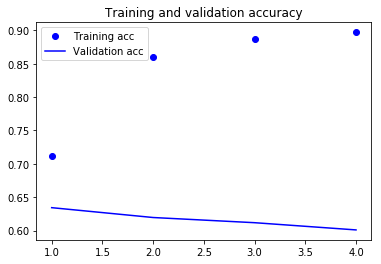

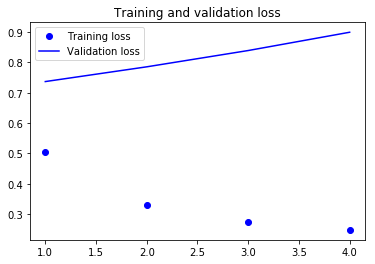

In [4]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [5]:
model.load_weights('bidirectional_LSTM_final_stem_stop.h5')
print("Classification Error on Test Set: ",model.evaluate(X_test,Y_test,verbose=0))

Classification Error on Test Set:  [0.8994239994916049, 0.6010090909090909]


In [6]:
test_tweets = ["Fuck you","I love you","I hate homework","I like homework", "Life sucks","Life is good",
               "Jesus loves me","Put a ring on it","Mercedes Benz: $20,000", "You suck",
                "The decision on Sergeant Bergdahl is a complete and total disgrace to our Country and to our Military.",
                "Does anybody really believe that a reporter, who nobody ever heard of, went to his mailbox and found my tax returns? @NBCNews FAKE NEWS!",
                "After Turkey call I will be heading over to Trump National Golf Club, Jupiter, to play golf (quickly) with Tiger Woods and Dustin Johnson. Then back to Mar-a-Lago for talks on bringing even more jobs and companies back to the USA!",
                "“The President has accomplished some absolutely historic things during this past year.” Thank you Charlie Kirk of Turning Points USA. Sadly, the Fake Mainstream Media will NEVER talk about our accomplishments in their end of year reviews. We are compiling a long & beautiful list.",
                "Crazy Joe Scarborough and dumb as a rock Mika are not bad people, but their low rated show is dominated by their NBC bosses. Too bad!",
                "Robert Pattinson should not take back Kristen Stewart. She cheated on him like a dog & will do it again--just watch. He can do much better!"]
temp=[]
temp_test_tweets=[]
for item in test_tweets:
    for word in item:
        if word.lower() not in stop_words:
            temp.append(stemmer.stem(word))
    temp_test_tweets.append([" ".join(temp),0])

tokenizer.fit_on_texts(temp_test_tweets)
sequences = tokenizer.texts_to_sequences(temp_test_tweets)


test_tweets_fit = sequence.pad_sequences(sequences, maxlen=max_tweet_length)

predictions = model.predict(test_tweets_fit)
for i in range(len(predictions)):
    print(test_tweets[i],"\n",predictions[i])

AttributeError: 'list' object has no attribute 'lower'